In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# ML
from sklearn.linear_model import SGDRegressor, Perceptron
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder, RareLabelCategoricalEncoder, MeanCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer
from feature_engine.discretisers import EqualWidthDiscretiser
from feature_engine.categorical_encoders import WoERatioCategoricalEncoder
from feature_engine import variable_transformers as vt
from feature_engine import categorical_encoders as ce

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from xgboost import XGBRegressor

import scipy.stats as stats


Using TensorFlow backend.


In [2]:
test = pd.read_csv('./test.csv')
print(test.shape)

train = pd.read_csv('./train.csv')
print(train.shape)
train.head()

(1459, 80)
(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Remove constant columns

In [3]:
num = 0
for col in train.columns:
    if train[col].nunique() == 1:
        train.drop(col, inplace=True, axis=1)
        test.drop(col, inplace=True, axis=1)
        num += 1
print(f'remove {num} constant columns')

remove 0 constant columns


### Remove columns with > 50% missing

In [4]:
rm = train.columns[train.isnull().mean() > 0.5]
print('Remove:', rm)
for col in rm:
    train.drop(columns=[col], inplace=True)
    test.drop(columns=[col], inplace=True)
print(train.shape)
print(test.shape)

Remove: Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
(1460, 77)
(1459, 76)


### Clean data

# EDA

## Correlation

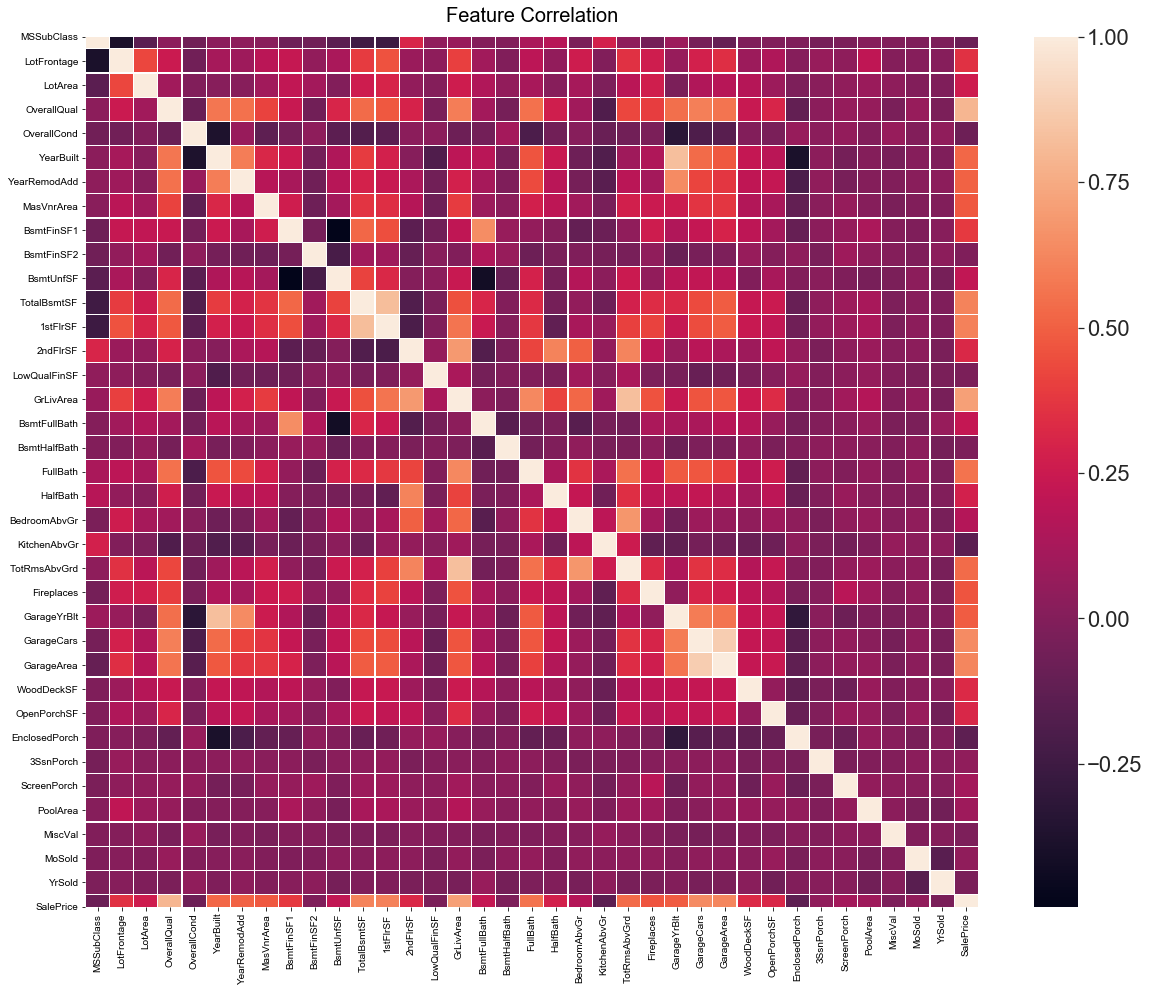

In [5]:
plt.figure(figsize=(20, 16))
plt.title('Feature Correlation', y=1.01, size=20)
sns.set(font_scale=2)
#sns.heatmap(train.drop(columns=['Id']).corr(), linewidths=0.1, annot=False)
sns.heatmap(train.drop(columns=['Id']).corr(), linewidths=0.1, annot=False)

* Can try feature selection.

## Add feature

In [6]:
for df in [train, test]:
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

### Outliers in train

LotFrontage upper threshold: 143.0
      LotFrontage  SalePrice
807         144.0     223500
909         149.0     174000
313         150.0     375000
1211        152.0     164000
1337        153.0      52500
1182        160.0     745000
1107        168.0     274725
197         174.0     235000
231         174.0     403000
1127        182.0     259000
1298        313.0     160000
934         313.0     242000


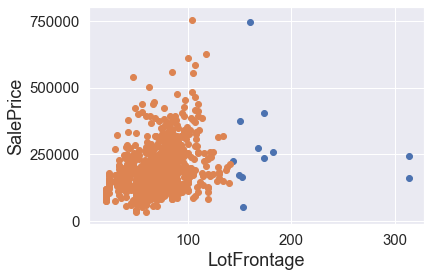

________________________________________________________________________________
LotArea upper threshold: 23745.5
      LotArea  SalePrice
939     24090     244400
1260    24682     181000
943     25000     143000
588     25095     143000
876     25286     132250
1383    25339     112000
197     25419     235000
1446    26142     157900
692     26178     335000
934     27650     242000
828     28698     185000
1057    29959     248000
171     31770     215000
1190    32463     168000
529     32668     200624
411     34650     145000
1184    35133     186700
1169    35760     625000
1287    36500     190000
271     39104     241500
523     40094     184750
848     45600     240000
661     46589     402000
53      50271     385000
384     53107     240000
457     53227     256000
769     53504     538000
1396    57200     160000
1298    63887     160000
451     70761     280000
706    115149     302000
249    159000     277000
335    164660     228950
313    215245     375000


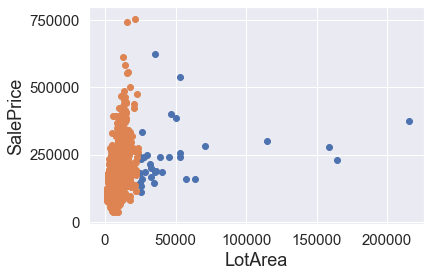

________________________________________________________________________________
OverallCond lower threshold: 2.0
     OverallCond  SalePrice
375            1      61000


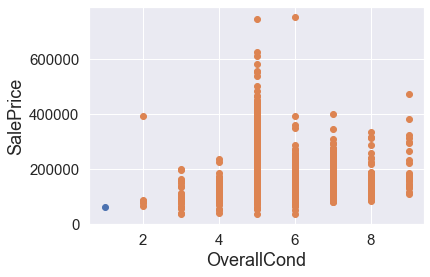

________________________________________________________________________________
MasVnrArea upper threshold: 664.0
      MasVnrArea  SalePrice
763        673.0     337000
1373       705.0     466500
1417       731.0     340000
178        748.0     501837
898        760.0     611657
523        762.0     184750
1228       766.0     367294
105        768.0     250000
477        772.0     380000
1289       788.0     281000
1298       796.0     160000
825        816.0     385000
798        860.0     485000
349        870.0     437154
755        894.0     172500
517        921.0     265000
224        922.0     386250
981        975.0     336000
58        1031.0     438780
808       1047.0     159950
70        1115.0     244000
115       1129.0     176000
691       1170.0     755000
1169      1378.0     625000
297       1600.0     239000


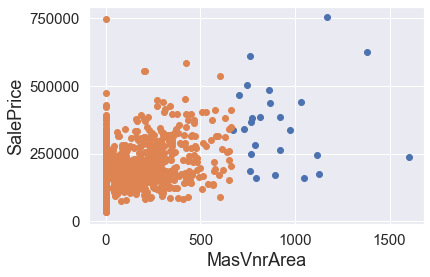

________________________________________________________________________________
BsmtFinSF1 upper threshold: 2849.0
      BsmtFinSF1  SalePrice
1298        5644     160000


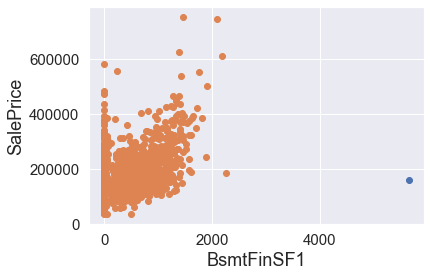

________________________________________________________________________________
BsmtFinSF2 upper threshold: 0.0
      BsmtFinSF2  SalePrice
129           28     150000
7             32     200000
645           35     143250
695           40     176000
1028          41     105000
...          ...        ...
153         1080     235000
854         1085     170000
470         1120     212000
542         1127     213250
322         1474     301000

[167 rows x 2 columns]


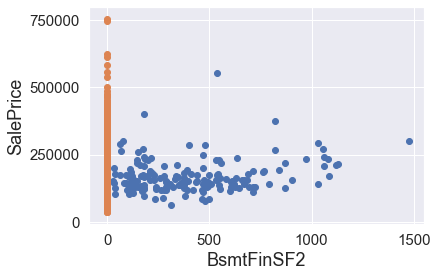

________________________________________________________________________________
TotalBsmtSF upper threshold: 2805.75
      TotalBsmtSF  SalePrice
440          3094     555000
523          3138     184750
496          3200     430000
332          3206     284000
1298         6110     160000


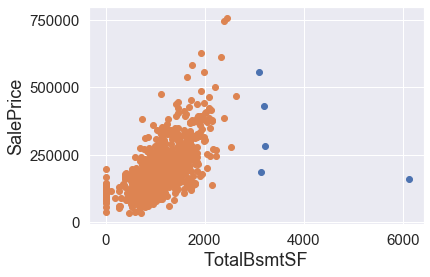

________________________________________________________________________________
1stFlrSF upper threshold: 2919.0
      1stFlrSF  SalePrice
523       3138     184750
496       3228     430000
1298      4692     160000


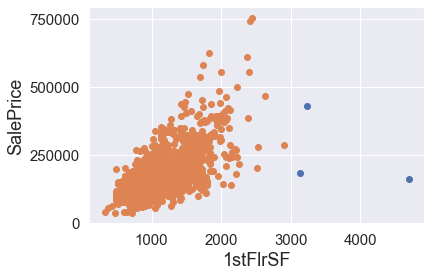

________________________________________________________________________________
LowQualFinSF upper threshold: 0.0
      LowQualFinSF  SalePrice
868             53     169000
1364            80     144152
829             80     147400
831             80     151000
945            120     124900
187            144     135000
589            156      79500
1349           205     122000
873            232     133000
125            234      84500
729            360     103000
51             360     114500
198            371     104000
1440           384     191000
263            390     130000
197            392     235000
1031           397     197000
267            420     179500
406            473     115000
1173           479     200500
883            481     118500
88             513      85000
1009           514     102000
635            515     200000
170            528     128500
185            572     475000


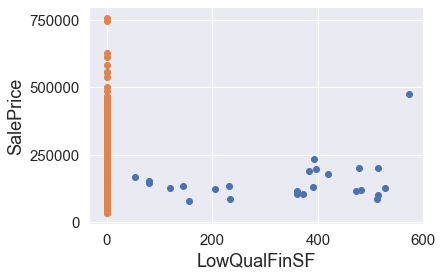

________________________________________________________________________________
GrLivArea upper threshold: 3718.5
      GrLivArea  SalePrice
691        4316     755000
1182       4476     745000
523        4676     184750
1298       5642     160000


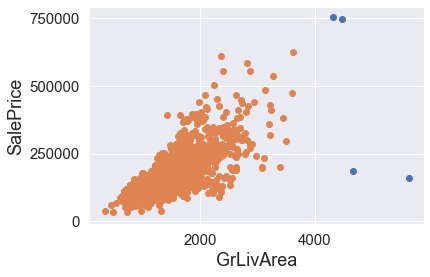

________________________________________________________________________________
BsmtHalfBath upper threshold: 0.0
      BsmtHalfBath  SalePrice
1072             1      91500
352              1      95000
658              1      97500
814              1     116000
931              1     117500
...            ...        ...
218              1     311500
1181             1     392500
691              1     755000
954              2     127500
597              2     194201

[82 rows x 2 columns]


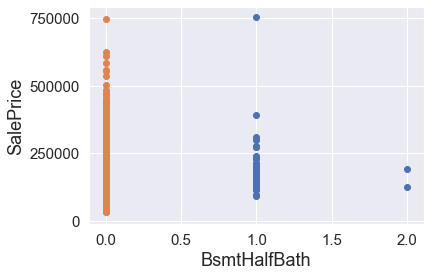

________________________________________________________________________________
BedroomAbvGr upper threshold: 6.0
     BedroomAbvGr  SalePrice
635             8     200000


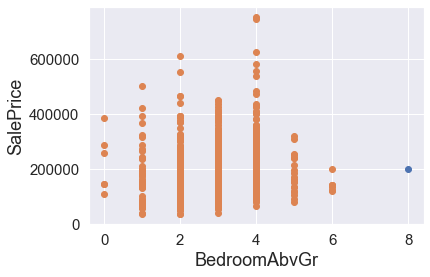

________________________________________________________________________________
KitchenAbvGr upper threshold: 1.0
      KitchenAbvGr  SalePrice
705              2      55000
39               2      82000
676              2      87000
342              2      87500
17               2      90000
...            ...        ...
1350             2     200000
529              2     200624
420              2     206300
809              3     106000
48               3     113000

[67 rows x 2 columns]


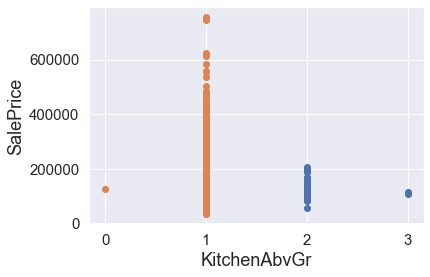

________________________________________________________________________________
TotRmsAbvGrd upper threshold: 13.0
     TotRmsAbvGrd  SalePrice
635            14     200000


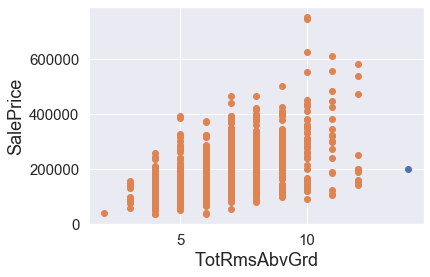

________________________________________________________________________________
GarageArea upper threshold: 1300.5
      GarageArea  SalePrice
1190        1356     168000
581         1390     253293
1298        1418     160000


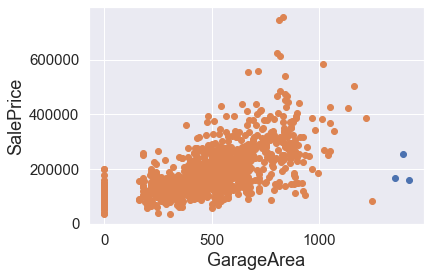

________________________________________________________________________________
WoodDeckSF upper threshold: 672.0
      WoodDeckSF  SalePrice
1068         728     151400
1459         736     147500
53           857     385000


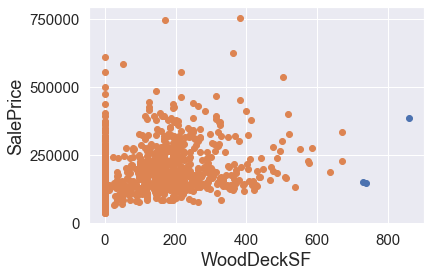

________________________________________________________________________________
OpenPorchSF upper threshold: 272.0
      OpenPorchSF  SalePrice
591           274     451950
961           282     272000
499           285     120000
1292          287     107500
713           288     129000
784           291     128000
1298          292     160000
1193          304     165000
645           312     143250
807           312     223500
996           319     136500
735           341     163000
875           364     303477
523           406     184750
854           418     170000
583           502     325000
495           523      34900
1328          547     256000


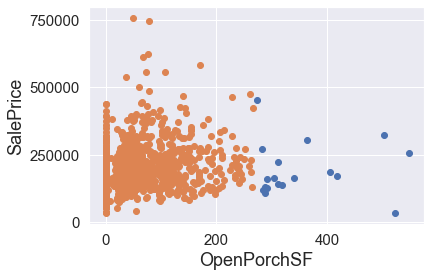

________________________________________________________________________________
EnclosedPorch upper threshold: 0.0
      EnclosedPorch  SalePrice
1059             19     220000
1349             20     122000
341              24      82000
198              30     104000
935              32      79900
...             ...        ...
1360            301     189000
939             318     244400
1197            330     144000
747             386     265979
197             552     235000

[208 rows x 2 columns]


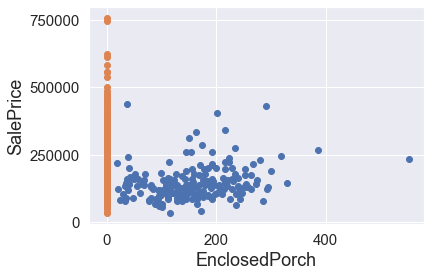

________________________________________________________________________________
3SsnPorch upper threshold: 0.0
      3SsnPorch  SalePrice
922          23     169990
1156         96     179900
120         130     180000
187         140     135000
546         144     210000
704         144     213000
1181        153     392500
889         162     149500
744         168     180000
941         168     214000
159         168     320000
182         180     120000
129         180     150000
726         182     222000
280         196     228500
1080        216     145000
1161        216     224000
237         238     194500
258         245     231500
1346        290     262500
1437        304     394617
5           320     143000
55          407     180500
205         508     180500


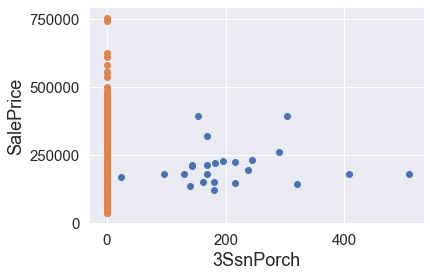

________________________________________________________________________________
ScreenPorch upper threshold: 0.0
      ScreenPorch  SalePrice
1443           40     121000
1012           53     165000
588            60     143000
995            63     121600
1259           80     151000
...           ...        ...
625           385     160000
426           396     275000
185           410     475000
1386          440     250000
1328          480     256000

[116 rows x 2 columns]


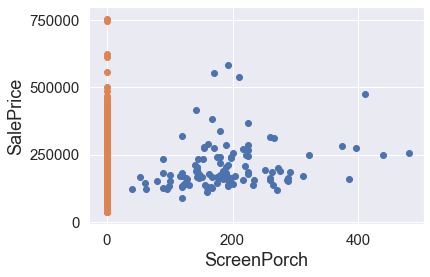

________________________________________________________________________________
PoolArea upper threshold: 0.0
      PoolArea  SalePrice
1298       480     160000
197        512     235000
1386       519     250000
1182       555     745000
1170       576     171000
810        648     181000
1423       738     274970


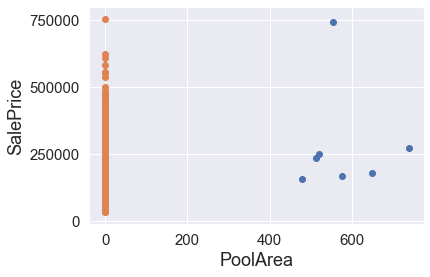

________________________________________________________________________________
MiscVal upper threshold: 0.0
      MiscVal  SalePrice
812        54      55993
7         350     200000
98        400      83000
51        400     114500
99        400     128950
867       400     129000
733       400     131400
502       400     140000
878       400     148000
953       400     172000
1210      400     189000
800       400     200000
338       400     202500
250       450      76500
106       450     100000
760       450     127500
214       450     161750
499       480     120000
95        480     185000
17        500      90000
725       500     120500
611       500     148000
813       500     157900
1076      500     170000
794       500     194500
766       500     196500
249       500     277000
1061      560      81000
589       600      79500
1252      600     130000
626       600     139900
634       600     144000
912       620      88000
5         700     143000
16        700  

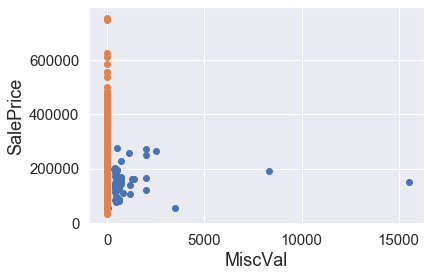

________________________________________________________________________________
TotalSF upper threshold: 5987.5
      TotalSF  SalePrice
496      6428     430000
691      6760     755000
1182     6872     745000
523      7814     184750
1298    11752     160000


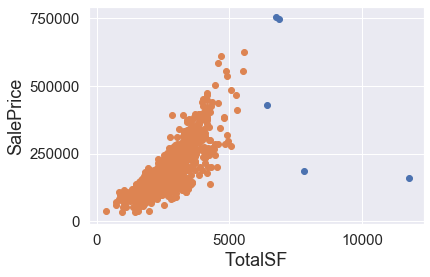

________________________________________________________________________________


In [7]:
normal = ['MoSold']
distance = 3
outliers = []
fig, ax = plt.subplots()
for i in train.columns:
    draw = False
    train_tmp = train.copy()  
    if i == 'SalePrice': continue
    if train[i].dtype != object:        
        if i in normal:
            upperThres = train[i].mean() + distance * train[i].std()
            lowerThres = train[i].mean() - distance * train[i].std()
        else:
            IQR = train[i].quantile(0.75) - train[i].quantile(0.25)
            upperThres = train[i].quantile(0.75) + (IQR * distance)
            lowerThres = train[i].quantile(0.25) - (IQR * distance)
    
        if train_tmp[i][train_tmp[i] > upperThres].any() == True:
            tmp = train_tmp[[i, 'SalePrice']][train_tmp[i] > upperThres]
            plt.scatter(tmp[i], tmp['SalePrice'], label=1)
            train_tmp.drop(train_tmp.index[list(tmp.index)],inplace=True)  
            print(f'{i} upper threshold: {upperThres}')
            print(tmp.sort_values(by=[i, 'SalePrice']))
            draw = True
            
        if train_tmp[i][train_tmp[i] < lowerThres].any() == True:            
            tmp = train_tmp[[i, 'SalePrice']][train_tmp[i] < lowerThres]
            plt.scatter(tmp[i], tmp['SalePrice'], label=2)
            train_tmp.drop(train_tmp.index[list(tmp.index)],inplace=True)
            print(f'{i} lower threshold: {lowerThres}')
            print(tmp.sort_values(by=[i, 'SalePrice']))
            draw = True
            
        if draw:
            plt.scatter(train_tmp[i], train_tmp['SalePrice'], label=3)
            plt.ylabel('SalePrice', fontsize=18)
            plt.xlabel(i, fontsize=18)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.show()
            print('________________________________________________________________________________')
            #break
            

In [8]:
outliers = [1298,934,              # LotFrontage
            706,249,335,313,       # LotArea
            297,                   # MasVnrArea
            1298,                  # BsmtFinSF1
            1298,                  # TotalBsmtSF
            1298,                  # 1stFlrSF
                                   # LowQualFinSF ...can drop this column
            523,1298,              # GrLivArea
            1328,                  # OpenPorchSF
            1230,346,              # MiscVal
           ]

outliers = list(set(outliers))
print(len(outliers))
outliers

11


[706, 934, 313, 297, 523, 1230, 335, 1328, 1298, 249, 346]

### Delete outliers in train

In [9]:
train.drop(train.index[outliers],inplace=True) 

for var in [train, test]:
    var.drop(columns=['LowQualFinSF'], axis=1, inplace=True)

# continuous.remove('LowQualFinSF')

print(train.shape)
print(test.shape)

(1449, 77)
(1459, 76)


In [10]:
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
both = pd.concat((train, test), sort=True).reset_index(drop=True)
print(both.shape)
print(train.shape)
print(test.shape)

(2908, 76)
(1449, 76)
(1459, 75)


### Separate types of data

In [11]:
def separate_data(data):
    print(data.shape)
    discrete = [var for var in data.columns if data[var].dtype!='O' and data[var].nunique()<=15]
    continuous = [var for var in data.columns if data[var].dtype!='O' and var not in discrete]

    # categorical
    categorical = [var for var in data.columns if data[var].dtype=='O'] # and var not in mixed]

    print('{} discrete variables'.format(len(discrete)))
    print('{} continuous variables'.format(len(continuous)))
    print('{} categorical variables'.format(len(categorical)))
    # print('{} mixed variables'.format(len(mixed)))
    
    assert(data.shape[1] == len(discrete) + len(continuous) + len(categorical))
    return discrete, continuous, categorical

discrete, continuous, categorical = separate_data(both)

(2908, 76)
14 discrete variables
23 continuous variables
39 categorical variables


### Inspect distributions

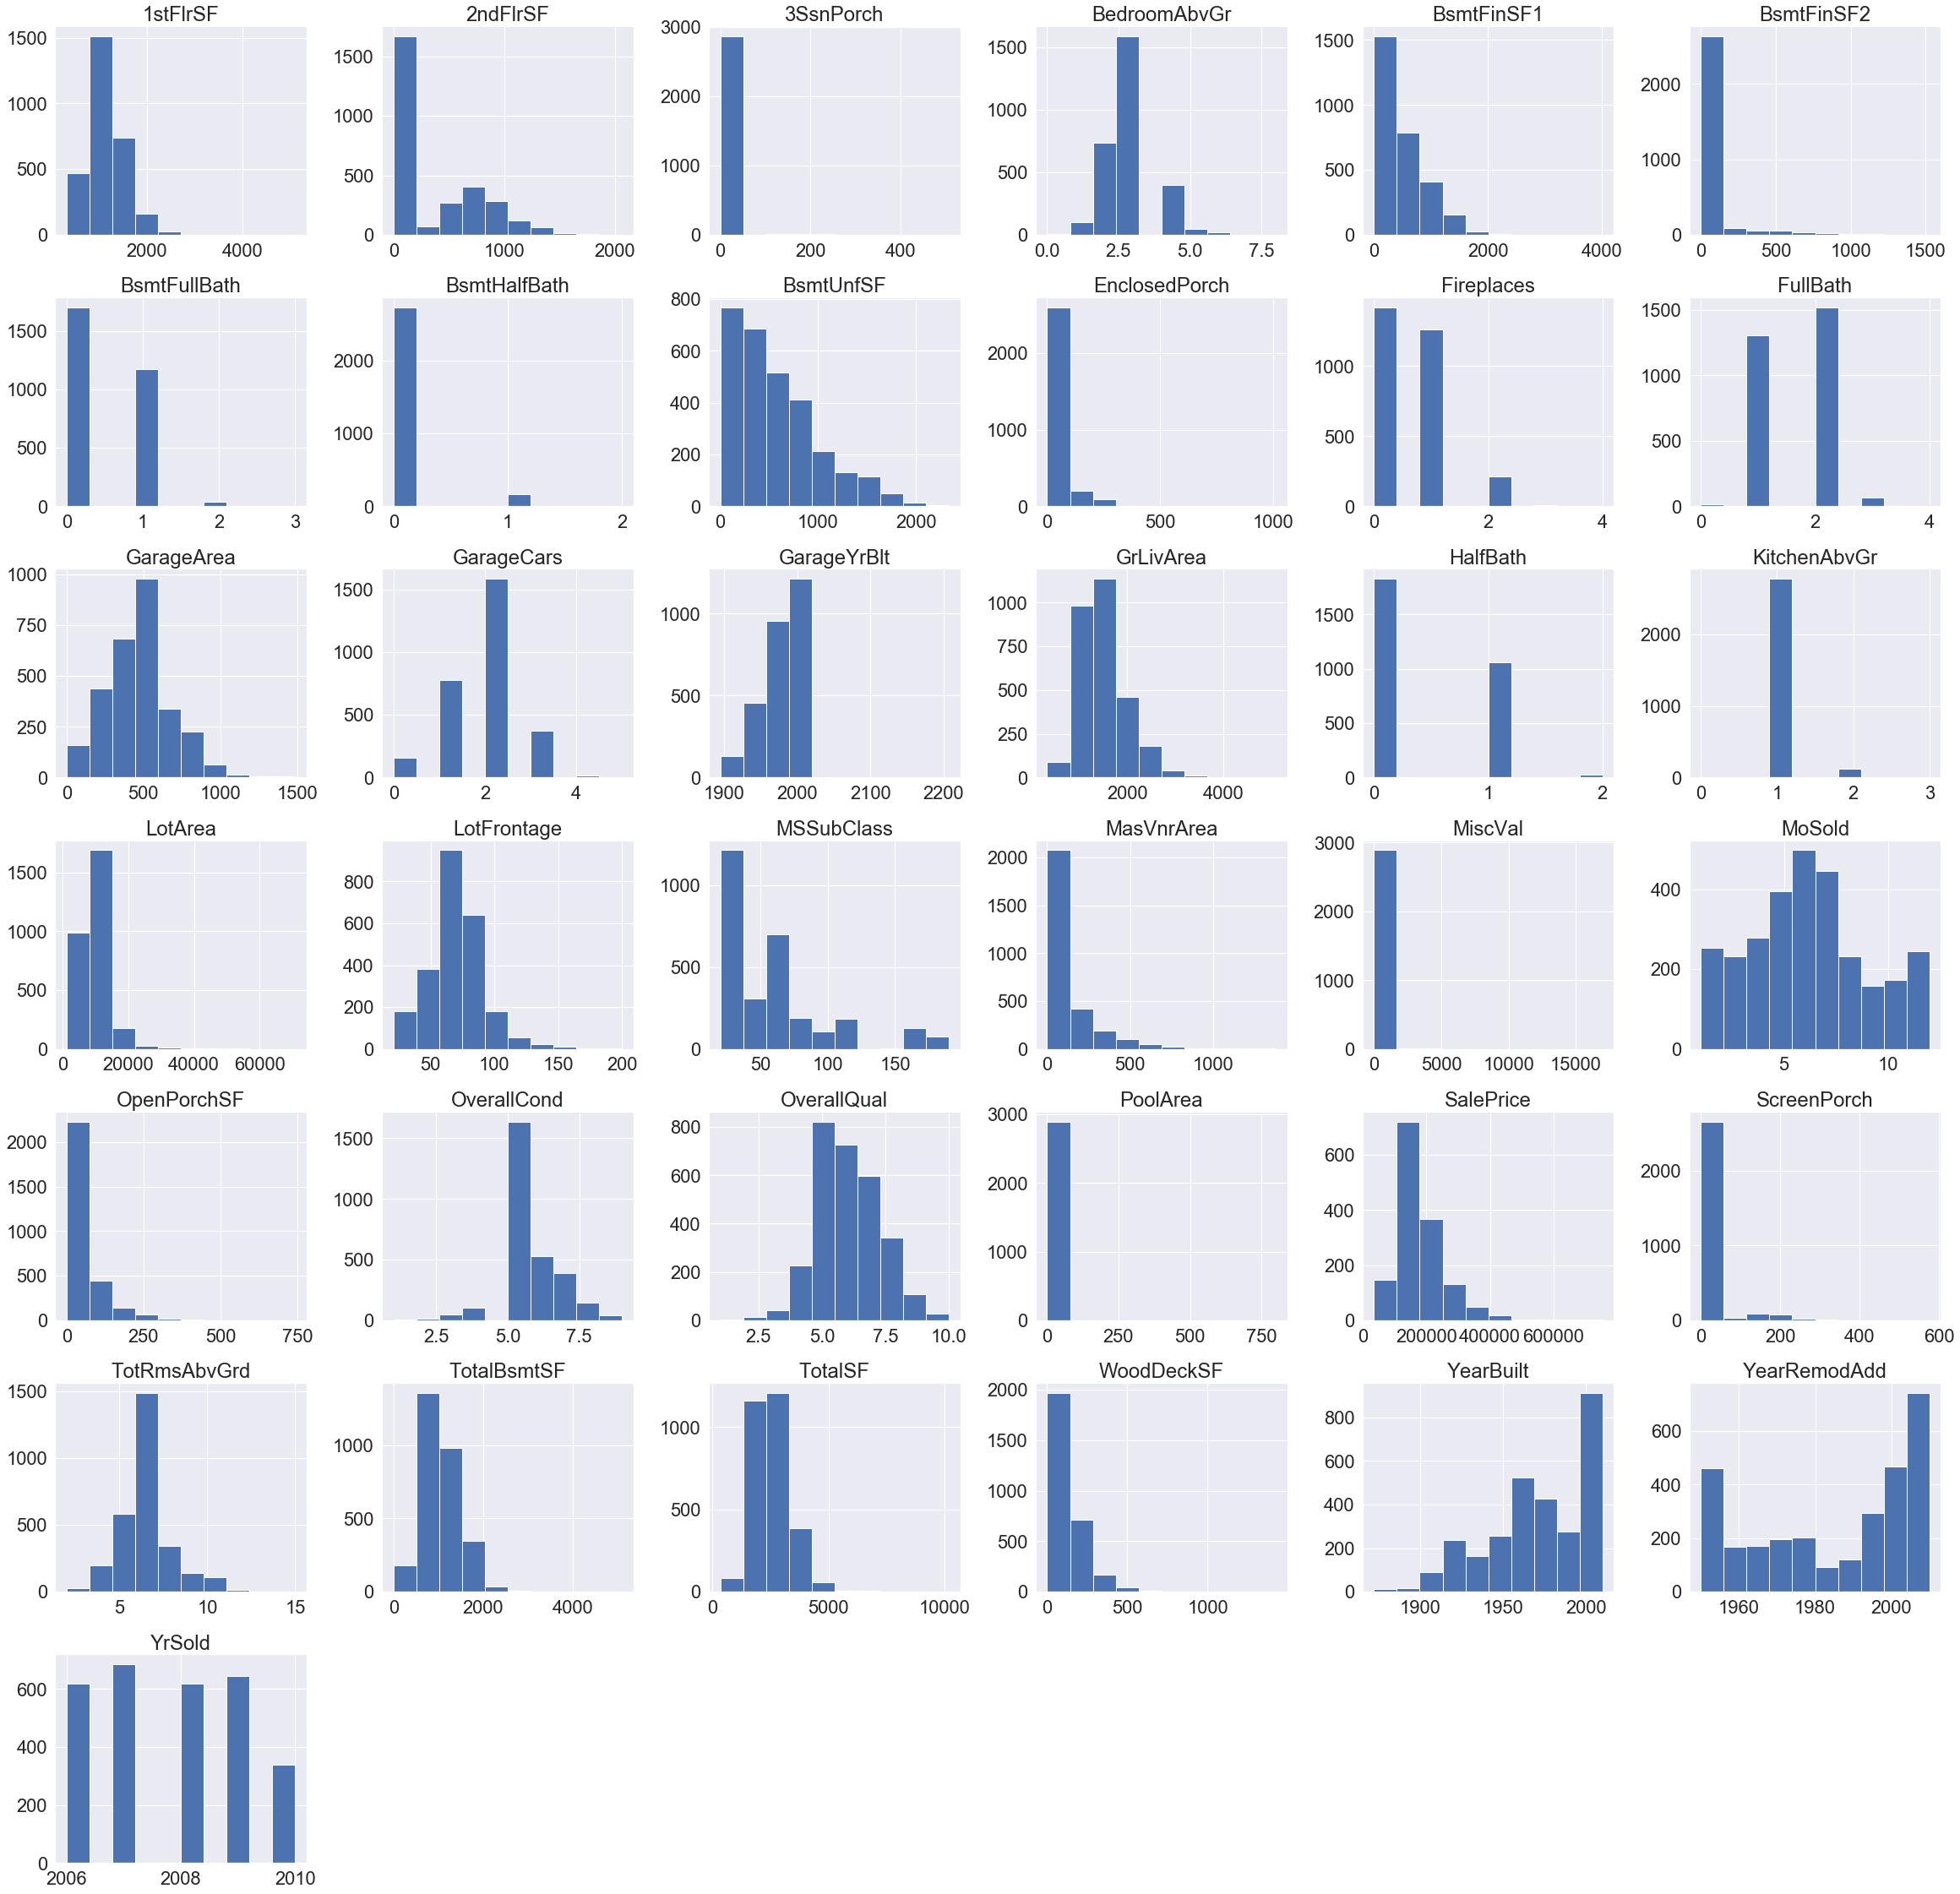

In [12]:
both.hist(figsize=(40, 40))
plt.show()

### Cardinality

Text(0, 0.5, 'Number of different categories')

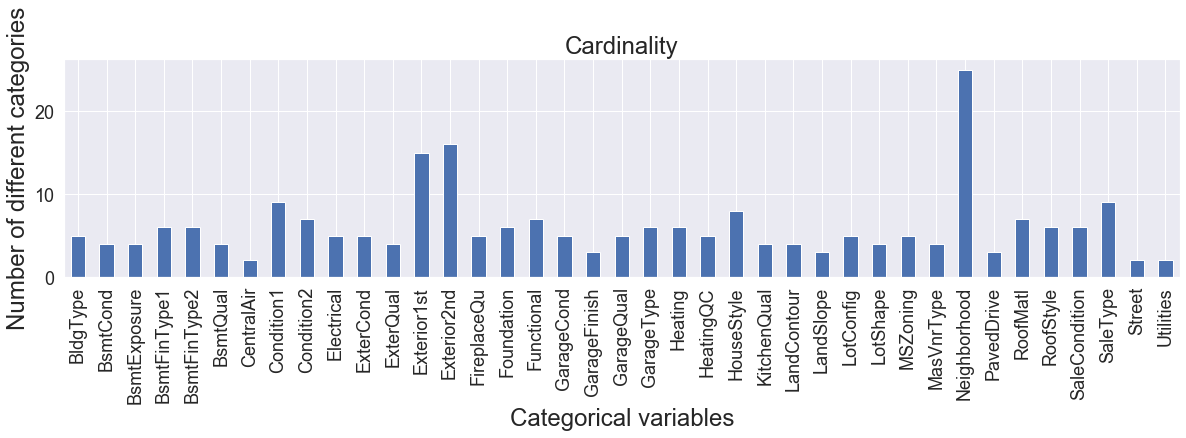

In [13]:
# plot number of categories per categorical variable

both[categorical].nunique().plot.bar(figsize=(20,4))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Cardinality')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

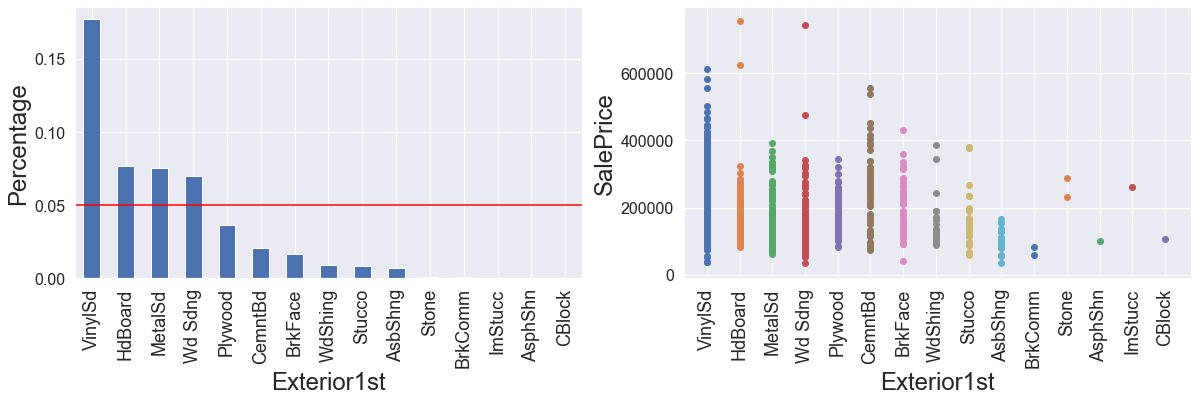

_____________________________________________________________________________________________


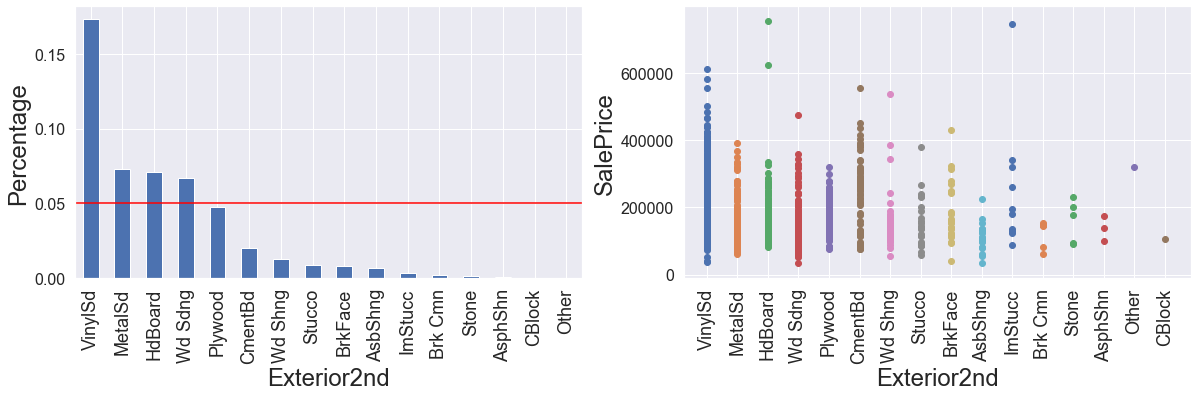

_____________________________________________________________________________________________


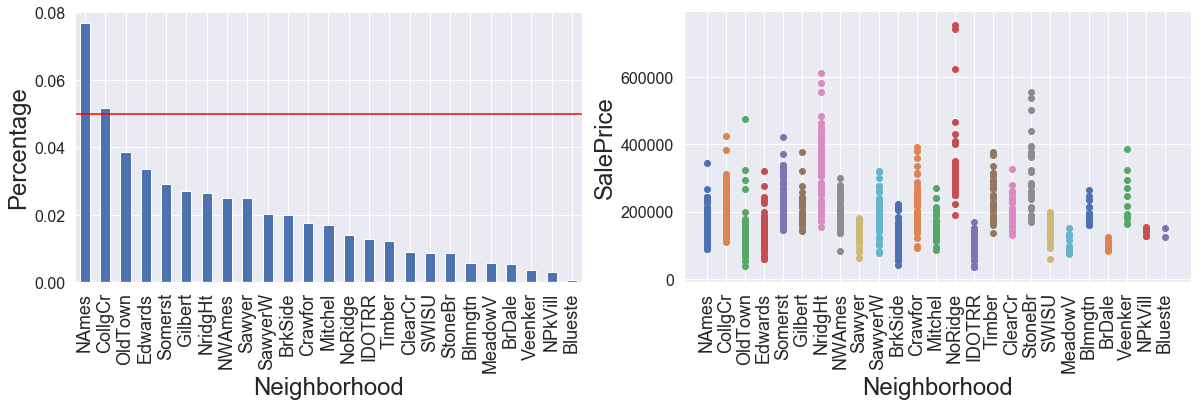

_____________________________________________________________________________________________


In [14]:
total_houses = len(both)
for col in categorical:
    if train[col].nunique() < 10: continue
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    temp_df = pd.Series(train[col].value_counts() / total_houses)
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage')
    plt.xticks(fontsize=18, rotation=90)
    plt.yticks(fontsize=16)
        
    #####
    xs, ys = [], []
    plt.subplot(1,2,2)
    for i in train[col].unique():
        tmp = train[train[col] == i]
        if (len(tmp) == 0):
            continue
        xs.append(tmp[col])
        ys.append(tmp['SalePrice'])
    xs = sorted(xs, key=lambda x: len(x), reverse=True)
    ys = sorted(ys, key=lambda y: len(y), reverse=True)
    for i in range(len(xs)):
        plt.scatter(xs[i], ys[i])
    plt.xticks(fontsize=18, rotation=90)
    plt.yticks(fontsize=16)
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.show()
    #break
    print('_____________________________________________________________________________________________')
    

## Missing

In [15]:
total = both.isnull().sum().sort_values(ascending=False)
percent = (both.isnull().sum()/both.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
SalePrice,1459,0.501719
FireplaceQu,1419,0.487964
LotFrontage,481,0.165406
GarageCond,159,0.054677
GarageFinish,159,0.054677
GarageQual,159,0.054677
GarageYrBlt,159,0.054677
GarageType,157,0.053989
BsmtExposure,82,0.028198
BsmtCond,82,0.028198


In [16]:
# FireplaceQu : data description says NA means "no fireplace"
both["FireplaceQu"] = both["FireplaceQu"].fillna("None")

In [17]:
# LotFrontage : Since the area of each street connected to the house property most likely 
# have a similar area to other houses in its neighborhood , we can fill in missing values 
# by the median LotFrontage of the neighborhood.
    
both["LotFrontage"] = both.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [18]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    both[col] = both[col].fillna('None')

In [19]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    both[col] = both[col].fillna(0)

In [20]:
both_backup = both.copy()

In [21]:
DATA = both
mmi = []
for var in discrete+continuous:
    if DATA[var].isnull().sum()==0 or var=='SalePrice': continue
    mmi.append(var)
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

print()
fci = []
for var in categorical:
    if DATA[var].isnull().sum() == 0 or var=='SalePrice': continue
    fci.append(var)
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

BsmtFullBath sum: 2 , mean: 0.001
BsmtHalfBath sum: 2 , mean: 0.001
BsmtFinSF1 sum: 1 , mean: 0.000
BsmtFinSF2 sum: 1 , mean: 0.000
BsmtUnfSF sum: 1 , mean: 0.000
MasVnrArea sum: 23 , mean: 0.008
TotalBsmtSF sum: 1 , mean: 0.000
TotalSF sum: 1 , mean: 0.000

BsmtCond sum: 82 , mean: 0.028
BsmtExposure sum: 82 , mean: 0.028
BsmtFinType1 sum: 79 , mean: 0.027
BsmtFinType2 sum: 80 , mean: 0.028
BsmtQual sum: 81 , mean: 0.028
Electrical sum: 1 , mean: 0.000
Exterior1st sum: 1 , mean: 0.000
Exterior2nd sum: 1 , mean: 0.000
Functional sum: 2 , mean: 0.001
KitchenQual sum: 1 , mean: 0.000
MSZoning sum: 4 , mean: 0.001
MasVnrType sum: 24 , mean: 0.008
SaleType sum: 1 , mean: 0.000
Utilities sum: 2 , mean: 0.001


In [22]:
train_num = len(train)

In [23]:
both = both_backup.copy()
train = both[:train_num]
print(both.shape)
print(train.shape)
print(test.shape)

(2908, 76)
(1449, 76)
(1459, 75)


### Get X, Y, TEST from the modified both

In [25]:
both["SalePrice"] = np.log1p(both["SalePrice"])
Y = both[['SalePrice']][:len(train)].copy()
both.drop(columns=['SalePrice'], inplace=True)
X = both[:len(train)].copy()
TEST = both[len(train):].copy()

assert(TEST.shape[1] == X.shape[1])

print(TEST.shape)
print(X.shape)
print(Y.shape)

#del both, train, test

(1459, 75)
(1449, 75)
(1449, 1)


In [26]:
DATA = X
for var in DATA.columns:
    if DATA[var].isnull().sum()==0: continue
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

print()

DATA = TEST
for var in DATA.columns:
    if DATA[var].isnull().sum()==0: continue
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

BsmtCond sum: 37 , mean: 0.026
BsmtExposure sum: 38 , mean: 0.026
BsmtFinType1 sum: 37 , mean: 0.026
BsmtFinType2 sum: 38 , mean: 0.026
BsmtQual sum: 37 , mean: 0.026
Electrical sum: 1 , mean: 0.001
MasVnrArea sum: 8 , mean: 0.006
MasVnrType sum: 8 , mean: 0.006

BsmtCond sum: 45 , mean: 0.031
BsmtExposure sum: 44 , mean: 0.030
BsmtFinSF1 sum: 1 , mean: 0.001
BsmtFinSF2 sum: 1 , mean: 0.001
BsmtFinType1 sum: 42 , mean: 0.029
BsmtFinType2 sum: 42 , mean: 0.029
BsmtFullBath sum: 2 , mean: 0.001
BsmtHalfBath sum: 2 , mean: 0.001
BsmtQual sum: 44 , mean: 0.030
BsmtUnfSF sum: 1 , mean: 0.001
Exterior1st sum: 1 , mean: 0.001
Exterior2nd sum: 1 , mean: 0.001
Functional sum: 2 , mean: 0.001
KitchenQual sum: 1 , mean: 0.001
MSZoning sum: 4 , mean: 0.003
MasVnrArea sum: 15 , mean: 0.010
MasVnrType sum: 16 , mean: 0.011
SaleType sum: 1 , mean: 0.001
TotalBsmtSF sum: 1 , mean: 0.001
TotalSF sum: 1 , mean: 0.001
Utilities sum: 2 , mean: 0.001


In [27]:
pipe = Pipeline([
    # ('nai', mdi.AddNaNBinaryImputer(variables=mmi+fci)),
    ('mmi', mdi.MeanMedianImputer('median', variables=mmi)),
    ('fci', mdi.FrequentCategoryImputer(variables=fci)),
#     ('rle', RareLabelCategoricalEncoder(tol=0.004, n_categories=10,
#                                         variables=categorical)),
    ('oce', OrdinalCategoricalEncoder('ordered', variables=categorical)),
])

pipe.fit(X, Y)
X = pipe.transform(X)
TEST = pipe.transform(TEST)

In [28]:
columns = [X.columns, test.columns]
scaler = StandardScaler()
scaler.fit(X)
for i, var in enumerate([X, TEST]):
    var = scaler.transform(var)
    var = pd.DataFrame(var, columns=columns[i])

### Check no missing values

In [29]:
DATA = X
for var in DATA.columns:
    if DATA[var].isnull().sum() ==0: continue
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

DATA = TEST
for var in DATA.columns:
    if DATA[var].isnull().sum() ==0: continue
    print(var, 'sum:', DATA[var].isnull().sum(), ", mean: %.3f" %DATA[var].isnull().mean())

In [30]:
from scipy.stats import norm, skew

for df in [X, TEST]:
    skewed_feats = df[df.columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

    from scipy.special import boxcox1p
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], lam)

There are 75 skewed numerical features to Box Cox transform
There are 75 skewed numerical features to Box Cox transform


## Various models

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,  test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((1159, 75), (290, 75))

X_preds and Y.values.ravel() should have the same value format to evaluate!

In [32]:
models = [
#     LinearSVR(),
#     SVR(),
#     SGDRegressor(),
#     KNeighborsRegressor(), 
#     DecisionTreeRegressor(),
#     NuSVR(),
    XGBRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    LGBMRegressor(),
    ExtraTreesRegressor(),
    BaggingRegressor()]

train_rmses, train_r2s, test_rmses, test_r2s, names = [], [], [], [], []
for model in models:
    pipe = Pipeline([('model', model)])
    gscv = GridSearchCV(pipe, param_grid={}, cv=5, n_jobs=-1)
    gscv.fit(X_train, y_train['SalePrice'].values.ravel())
    X_train_preds = gscv.predict(X_train)
    X_test_preds = gscv.predict(X_test)
    
    train_rmse = sqrt(mean_squared_error(y_train, X_train_preds))
    test_rmse = sqrt(mean_squared_error(y_test, X_test_preds))
    train_r2 = r2_score(y_train, X_train_preds)
    test_r2 = r2_score(y_test, X_test_preds)
    
    names.append(model.__class__.__name__)
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)
    
models = pd.DataFrame({'Model': names, 'train RMSE': train_rmses, 'train R2': train_r2s,
                       'test RMSE': test_rmses, 'test R2': test_r2s})
models.sort_values(by=['test RMSE', 'test R2'], ascending=True)

,Model,train RMSE,train R2,test RMSE,test R2
3,GradientBoostingRegressor,0.075837,0.964451,0.111725,0.916579
5,ExtraTreesRegressor,0.000009,1.000000,0.114926,0.911730
4,LGBMRegressor,0.040652,0.989785,0.115967,0.910125
0,XGBRegressor,0.007770,0.999627,0.116746,0.908913
1,RandomForestRegressor,0.050491,0.984242,0.121095,0.901999
6,BaggingRegressor,0.059932,0.977799,0.130483,0.886215
2,AdaBoostRegressor,0.137204,0.883640,0.147894,0.853824


## Tune the best model

In [33]:
pipe = Pipeline([
    ('model', GradientBoostingRegressor(random_state=0))
])
param_grid = {
    'model__min_samples_leaf': [1,5],
    'model__n_estimators':[100,200],
    'model__min_samples_split':[2,4]
}
gscv = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gscv.fit(X_train, y_train)
X_train_preds = gscv.predict(X_train)
X_test_preds = gscv.predict(X_test)

print('gscv.best_params_:', gscv.best_params_)
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

# print('Train accuracy: %.3f' %(accuracy_score(y_train, x_train_preds)))
# print('Test accuracy: %.3f' %(accuracy_score(y_test, x_test_preds)))
# print('best params:', gscv.best_params_)

/Users/paulin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gscv.best_params_: {'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 200}
train mse: 0.003973665326821437
train rmse: 0.06303701552914316
train r2: 0.9754382296613243

test mse: 0.012589363510013265
test rmse: 0.11220233290806954
test r2: 0.9158647530594479


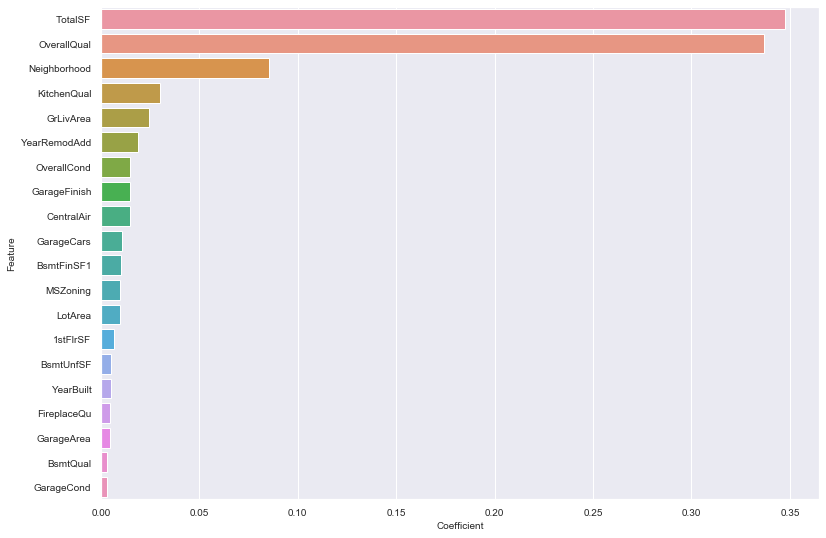

In [37]:
importance = pd.Series(gscv.best_estimator_['model'].feature_importances_)
importance.index =X_train.columns
importance.sort_values(inplace=True, ascending=False)
importance = importance[:20]

feature_names = list(importance.index)
feature_coeffs = list(importance)
feature_coef_df = pd.DataFrame(list(zip(feature_names, feature_coeffs)), 
                               columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x='Coefficient', y='Feature', data=feature_coef_df.iloc[:len(feature_names)+1], ax=ax)
ax.set_xlabel(ax.get_xlabel(), fontsize=10)
ax.set_ylabel(ax.get_ylabel(), fontsize=10)
ax.tick_params(labelsize=10)
plt.tight_layout()
#ax.get_figure().savefig(f'./imgs/feature_importance.png')
